In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from x2 import X2Env
from stable_baselines3.common.env_checker import check_env

check_env(X2Env())

In [3]:
from stable_baselines3 import PPO
from uuid import uuid4

env = X2Env()

model = PPO("MlpPolicy", env, seed=0, learning_rate=0.0001, batch_size=256)

In [5]:
from eval import eval_model

N = 25_000

all_rews = []

uuid = uuid4()
print(f'run id: {uuid}')

for i in range(10):
    model.learn(total_timesteps=N)
    rewards = eval_model(model)

    iters = N * (i + 1) / 1000
    print(f'after {iters}k learning steps, mean rewards: {rewards.mean()}, std={rewards.std()}')

    model.save(f"models/{uuid}_{iters}k.model")

    all_rews.append(rewards)

run id: 9e6b792d-7f0d-4de2-bb0d-b3a86a19ee68
after 25.0k learning steps, mean rewards: 19.4353, std=7.1258272439064925


array([[<AxesSubplot:title={'center':'reward'}>]], dtype=object)

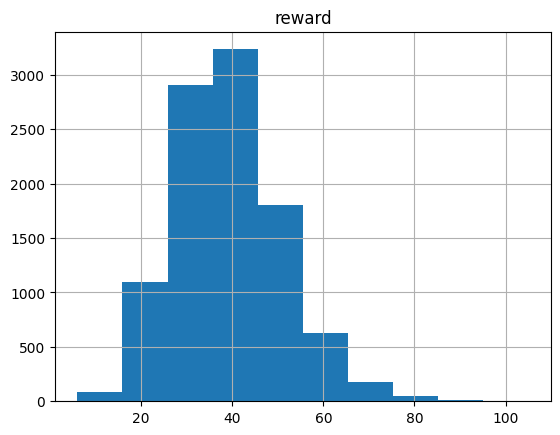

In [59]:
import pandas as pd

rewards = all_rews[-1]

df = pd.DataFrame(rewards, columns=["reward"])
df.hist()

In [307]:
import numpy as np

seed = int(np.argmax(rewards))
print(seed, print(np.max(rewards)))

env = X2Env()
state, _ = env.reset(seed=seed)

iter = 0

105
6134 None


In [428]:
from x2 import print_grid

s = env.get_state()

print_grid(s.grid)

action, _ = model.predict(state, deterministic=True)

print(f"iter: {iter}, next: {s.next_play} action: {action}")

next_state, reward, done, _, _ = env.step(action)

print_grid(s.grid)
iter += 1

0006 0001 0010 0006 0002
0004 0003 0009 0001 0006
0006 0001 0007 0008 0005
0001 0003 0006 0007 0004
0003 0007 0005 0006 0001
iter: 120, next: 6 action: 0
0006 0001 0010 0006 0002
0004 0003 0009 0001 0006
0006 0001 0007 0008 0005
0001 0003 0006 0007 0004
0003 0007 0005 0006 0001
